In [6]:
import math
import time
import pinocchio as pin
import numpy as np
from numpy.random import rand
from numpy.linalg import inv,pinv,norm,eig,svd
import matplotlib.pylab as plt; plt.ion()
import quadprog
from tp6.robot_hand import RobotHand
from tp6.meshcat_viewer_wrapper import MeshcatVisualizer
from tp6.traj_ref import TrajRef
from tp6.collision_wrapper import CollisionWrapper

In [7]:
robot=RobotHand()
viz = MeshcatVisualizer(robot)
viz.display(robot.q0)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [8]:
qdes = TrajRef(robot.q0,omega = np.array([0,0,1,0,4,2,1,0,2,2,0,0,0,3]),amplitude=1.6)
colwrap = CollisionWrapper(robot)

q = robot.q0.copy()
vq = np.zeros(robot.model.nv)
dt = 1e-3
Kp = 500
Kv = 2 * np.sqrt(Kp)
KpCol = -2e5
KvCol = 2*math.sqrt(abs(KpCol))
hq = []
hqdes = []
previousContacts = []
for it in range(10000):
    t = it*dt
    ### Compute M, b, tauq and self-acceleration (q0)
    M = pin.crba(robot.model,robot.data,q)
    b = pin.rnea(robot.model,robot.data,q,vq,np.zeros(robot.model.nv))
    tauq = -Kp*(q - qdes(t)) - Kv*(vq-qdes.velocity(t))
    aq = inv(M) @ (tauq - b)
    
    #get the collisions
    colwrap.computeCollisions(q)
    collisions = colwrap.getCollisionList()
    if (len(collisions) > 0): # there is a collision !
        # get the distances and select those with distances <= 1e-3
        dist=colwrap.getCollisionDistances(collisions)
        myCollisions = []
        isNewCollision = False
        for i in range(len(collisions)):
            if (dist[i] < 1e-3):
                myCollisions.append(collisions[i])
                isNewCollision = isNewCollision or (not(collisions[i] in previousContacts))
                
        #compute the Jacobians
        J = colwrap.getCollisionJacobian(myCollisions)
        dist=colwrap.getCollisionDistances(myCollisions)
        
        d = -J@aq
        
        #if there is new collisions, nullify the velocities
        if(isNewCollision):
            vq = vq - pinv(J)@J@vq
            
        #compute the acceleration thanks to quadprog
        colwrap.computeCollisions(q,vq)
        coriollis = np.squeeze(colwrap.getCollisionJdotQdot(myCollisions).T,axis=0)
        
        d -= KpCol*dist+KvCol*J@vq+coriollis
        b = np.zeros(robot.model.nv)
        # a = ddotq - ddotq0
        [a,cost,_,niter,lag,iact] = quadprog.solve_qp(M,b,J.T,d) #cf remarque
        aq += a
        previousContacts = myCollisions
        
    vq += aq*dt
    q = pin.integrate(robot.model,q,vq*dt)
    hq.append(q.copy())
    hqdes.append(qdes(t).copy())

    if it%20==0: 
        viz.display(q)
        time.sleep(dt)          

Text(0.5,0,'Iterations')

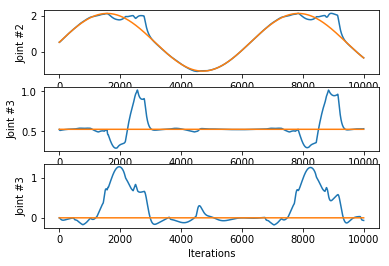

In [9]:
plt.subplot(311)
plt.plot([q[2] for q in hq])
plt.plot([q[2] for q in hqdes])
plt.ylabel('Joint #2')
plt.subplot(312)
plt.plot([q[3] for q in hq])
plt.plot([q[3] for q in hqdes]);
plt.ylabel('Joint #3')
plt.subplot(313)
plt.plot([q[1] for q in hq])
plt.plot([q[1] for q in hqdes]);
plt.ylabel('Joint #3')
plt.xlabel('Iterations')

## Remarque pour QuadProg

The joint acceleration with PD penetration corrector can be written as a minimization problem using Gauss principle:
$$min \quad \frac{1}{2}  (\ddot{q} - \ddot{q}_0 )^T M (\ddot{q} - \ddot{q}_0 )$$
$$s.t. \quad J \ddot{q} >= -\dot{J}\dot{q} -K_p dist -K_v J \dot{q} $$
where $ \ddot{q}_0 = M^{-1} (\tau-b)$ is the free acceleration

By assuming $aq = \ddot{q}-\ddot{q}_0$, we get the following formula: 

$$min \quad \frac{1}{2}  a_q^T M a_q$$
$$s.t. \quad J a_q  >= -J \ddot{q}_0 -\dot{J}\dot{q} -K_p dist -K_v J \dot{q} $$
where $\ddot{q} =a_q+\ddot{q}_0$ 

The general formula of quadprog is:
$$min \quad \frac{1}{2}  x^T A x - b^T x$$
$$s.t. \quad C x >= d $$
So we have :
$$A = M$$
$$b = 0$$
$$C = J$$
$$d = -J \ddot{q}_0 -\dot{J}\dot{q} -K_p dist -K_v J \dot{q}$$d
    